# SIGN LANGUANGE USING RESNET - 50

### IMPORT LIBRARY

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

# Data & Visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Image Processing
from PIL import Image
from tensorflow.keras.preprocessing import image, ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50

# Model Building
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout, Lambda,
    GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam

# Evaluation
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, roc_curve, auc,
    classification_report
)


### SPLIT DATASET

In [ ]:
# Change to your own path
dataset_path = "./DatasetHuruf/Mentahan"
train_path = "./DatasetHuruf/Train"
test_path = "./DatasetHuruf/Test"
val_path = "./DatasetHuruf/Valid"

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        random.shuffle(images)  

        train_split = int(0.7 * len(images))  
        val_split = int(0.1 * len(images)) + train_split  

        train_images = images[:train_split]
        val_images = images[train_split:val_split]
        test_images = images[val_split:]  

        os.makedirs(os.path.join(train_path, class_folder), exist_ok=True)
        os.makedirs(os.path.join(val_path, class_folder), exist_ok=True)
        os.makedirs(os.path.join(test_path, class_folder), exist_ok=True)

        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_path, class_folder, img))

        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_path, class_folder, img))

        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_path, class_folder, img))

print("Dataset telah dibagi ke dalam folder train, val, dan test.")



### DATA AUGMENTATION

In [52]:
# Change to your own path
train_path = './DatasetHuruf/Train' 
test_path = './DatasetHuruf/Test'

# Data generator for training with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.2, 1.2]
)

# Data generator for validation & testing with split
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

# Load training data
train_batches = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

# Validasi data: 20% from test_path
valid_batches = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=46
)

# Testing data: 80% from test_path
test_batches = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    shuffle=False,
    seed=46
)

Found 3696 images belonging to 24 classes.
Found 192 images belonging to 24 classes.
Found 864 images belonging to 24 classes.


### IMPLEMENT RESNET - 50 MODEL

In [53]:
input_tensor = Input(shape=(224, 224, 3))

resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

for layer in resnet_base.layers:
    layer.trainable = False

set_trainable = False
for layer in resnet_base.layers:
    if layer.name.startswith('conv5_block1'):
        set_trainable = True
    if set_trainable:
        layer.trainable = True

x = GlobalAveragePooling2D()(resnet_base.output)
predictions = Dense(24, activation='softmax')(x)

# Buat model akhir
resnet_model = Model(inputs=resnet_base.input, outputs=predictions)



In [54]:
resnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,636,888 (90.17 MB)

 Trainable params: 15,025,176 (57.32 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [ ]:
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [56]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = resnet_model.fit(
    train_batches,
    steps_per_epoch=58,          # total_data_train / batch_size
    validation_data=valid_batches,
    validation_steps=8,          # total_data_val / batch_size
    epochs=100,
    callbacks=[early_stopping]
)


Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.4078 - loss: 2.1689 - val_accuracy: 0.9062 - val_loss: 0.2788
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - accuracy: 0.9354 - loss: 0.2494 - val_accuracy: 0.9688 - val_loss: 0.0897
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - accuracy: 0.9708 - loss: 0.1203 - val_accuracy: 0.9792 - val_loss: 0.1069
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 246s 4s/step - accuracy: 0.9769 - loss: 0.0855 - val_accuracy: 0.9688 - val_loss: 0.0836
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.9802 - loss: 0.0675 - val_accuracy: 0.9688 - val_loss: 0.0748
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 250s 4s/step - accuracy: 0.9845 - loss: 0.0594 - val_accuracy: 0.9792 - val_loss: 0.0808
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - accuracy: 0.9757 - loss: 0.0828 - val_accuracy: 0.9896 - val_loss: 0.0435
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.9816 - loss: 0.0585 - val_accuracy: 0.

### MODEL RESULTS WITH PLOTTING

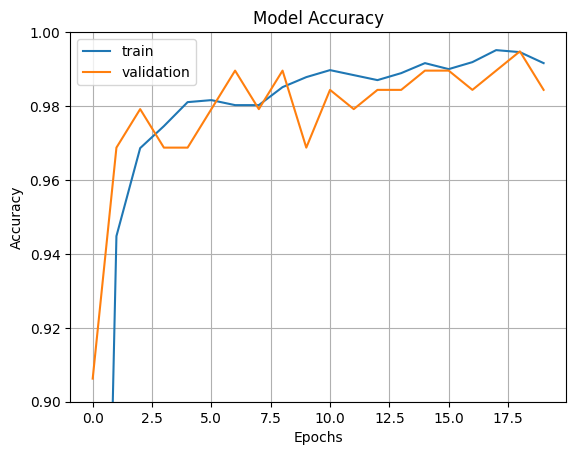

In [57]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.9,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

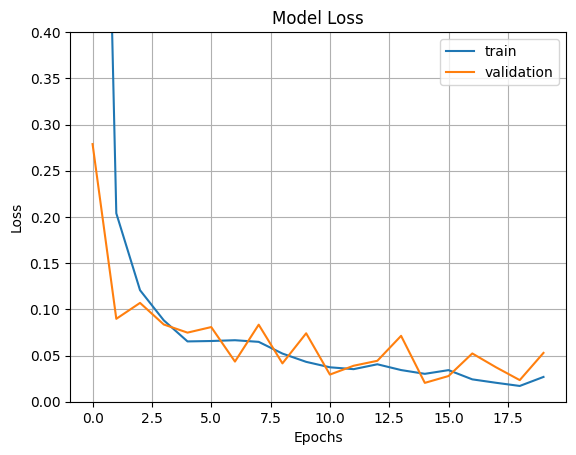

In [58]:
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=0.4)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

### TESTING DATA

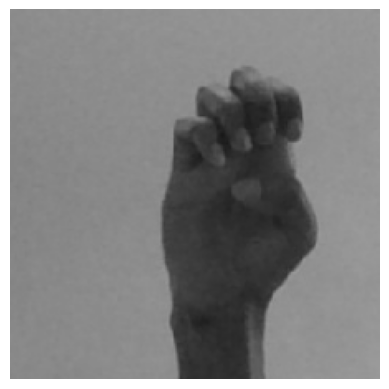

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: E


In [59]:
label_dict = {
    0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G", 7: "H", 8: "I", 9: "K",
    10: "L", 11: "M", 12: "N", 13: "O", 14: "P", 15: "Q", 16: "R", 17: "S",
    18: "T", 19: "U", 20: "V", 21: "W", 22: "X", 23: "Y"
}
# Load image
img = "./DatasetHuruf/Test/E/1645946625.685273_T.jpg"
img_test = image.load_img(img, target_size=(224, 224))
x = image.img_to_array(img_test)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) 

# Predict
plt.imshow(img_test)
plt.axis('off')
plt.show()

pred = resnet_model.predict(x)
label_index = np.argmax(pred)
predicted_class = label_dict[label_index]

print("Predicted Class:", predicted_class)

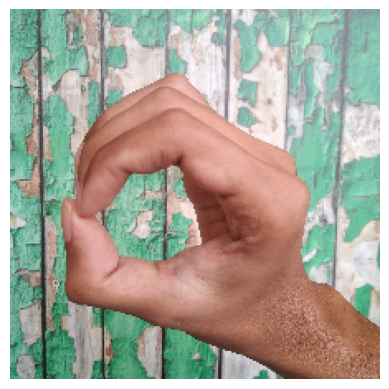

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted Class: O


In [60]:
from keras.preprocessing import image
label_dict = {
    0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G", 7: "H", 8: "I", 9: "K",
    10: "L", 11: "M", 12: "N", 13: "O", 14: "P", 15: "Q", 16: "R", 17: "S",
    18: "T", 19: "U", 20: "V", 21: "W", 22: "X", 23: "Y"
}

# Load image
img = "./DatasetHuruf/Test/O/IMG_20220221_112745.jpg"
img_test = image.load_img(img, target_size=(224, 224))
x = image.img_to_array(img_test)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) 

# Predict
plt.imshow(img_test)
plt.axis('off')
plt.show()

pred = resnet_model.predict(x)
label_index = np.argmax(pred)
predicted_class = label_dict[label_index]

print("Predicted Class:", predicted_class)

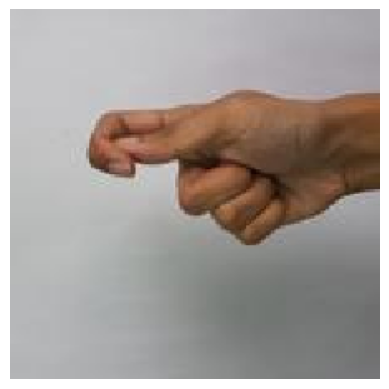

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted Class: T


In [61]:
label_dict = {
    0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G", 7: "H", 8: "I", 9: "K",
    10: "L", 11: "M", 12: "N", 13: "O", 14: "P", 15: "Q", 16: "R", 17: "S",
    18: "T", 19: "U", 20: "V", 21: "W", 22: "X", 23: "Y"
}

# Load image
img_path = "./DatasetHuruf/Test/T/20201018_121643_009.jpg"
img_test = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img_test)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) 

# Predict
plt.imshow(img_test)
plt.axis('off')
plt.show()

pred = resnet_model.predict(x)
label_index = np.argmax(pred)
predicted_class = label_dict[label_index]

print("Predicted Class:", predicted_class)

### EVALUATION

In [63]:
predictions = resnet_model.predict(test_batches, steps=len(test_batches), verbose=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step


In [66]:
y_true = test_batches.classes  
y_pred = predictions.argmax(axis=1)  

cm = confusion_matrix(y_true, y_pred)

In [68]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[35  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 35  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 33  0  0  0  0  2  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 36  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 35  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  1 34  0  0  0  0  0  0  

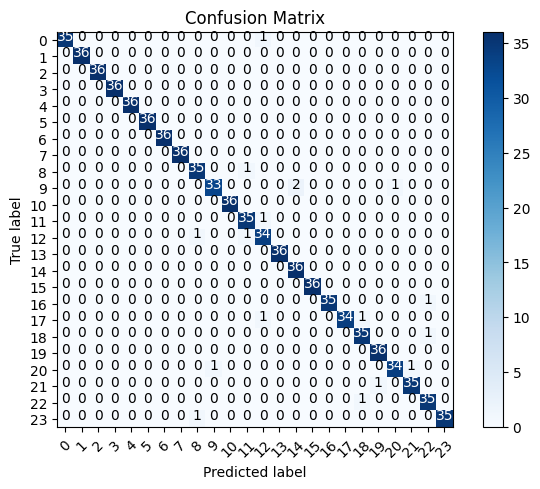

In [69]:
import itertools
cm_plot_lables = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','10','11','12','13','14','15','16','17','18','19','20','21','22','23']
plot_confusion_matrix(cm, cm_plot_lables, title='Confusion Matrix')

In [70]:
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', precision, recall, f1]
)

In [72]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       1.00      1.00      1.00        36
           2       1.00      1.00      1.00        36
           3       1.00      1.00      1.00        36
           4       1.00      1.00      1.00        36
           5       1.00      1.00      1.00        36
           6       1.00      1.00      1.00        36
           7       1.00      1.00      1.00        36
           8       0.95      0.97      0.96        36
           9       0.97      0.92      0.94        36
          10       1.00      1.00      1.00        36
          11       0.95      0.97      0.96        36
          12       0.92      0.94      0.93        36
          13       1.00      1.00      1.00        36
          14       0.95      1.00      0.97        36
          15       1.00      1.00      1.00        36
          16       1.00      0.97      0.99        36
          17       1.00    

### SAVE MODEL

In [73]:
resnet_model.save('Resnet_model.h5')